# Experiment 2


In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# download the dataset content from google drive to google colab vm (this is done for efficiency reasons)
!cp -r /content/drive/MyDrive/CIDL_Project/dataset/preprocessed_annotations/preprocessed_annotations .
!cp -r /content/drive/MyDrive/CIDL_Project/dataset/preprocessed_images/preprocessed_images .

In [3]:
import tensorflow as tf

# store the images using a keras utility
image_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='./preprocessed_images',
    labels = None,
    label_mode=None,
    batch_size=None,
    color_mode='rgb',
    # specify the size of the images, all the images are rescaled to this size
    image_size=(128, 128),
    shuffle=False,
    crop_to_aspect_ratio=False,
)

Found 1861 files belonging to 1 classes.


The functions in the next cell are an adaptation of the code used in the [Keras tutorial of RetinaNet](https://keras.io/examples/vision/retinanet/)



In [4]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["without mask", "with mask"]

def visualize_image(image, figsize=(7, 7)):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    return plt

def visualize_images(images, figsize=(7, 7)):
  for image in images:
    visualize_image(image, figsize)

def visualize_detections(
    image, box, label, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    # the function gets as input the image, the bounding box in xmin, ymin, xmax and ymax format and the label as an integer (0 or 1)
    plt = visualize_image(image)
    ax = plt.gca()
    text = "{}:".format(labels[label])
    x1, y1, x2, y2 = box
    w, h = x2 - x1, y2 - y1
    patch = plt.Rectangle(
        [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
    )
    ax.add_patch(patch)
    ax.text(
        x1,
        y1,
        text,
        bbox={"facecolor": color, "alpha": 0.4},
        clip_box=ax.clipbox,
        clip_on=True,
    )
    plt.show()
    return ax

In [5]:
def rescale_bbox(image_shape, bbox):
  # bbox is a tensor with the normalized coordinates of the bounding box expressed in xmin, ymin, xmax, ymax format
  # the function denormalizes the coordinates and returns the corresponding tensor
  return tf.stack(
        [
            bbox[0] * image_shape[1],
            bbox[1] * image_shape[0],
            bbox[2] * image_shape[1],
            bbox[3] * image_shape[0]
        ])

The functions in the next cell are an adaptation of the code used in the [Keras tutorial of RetinaNet](https://keras.io/examples/vision/retinanet/)

The coordinates of the bounding boxes can be expressed in two formats:
*   xmin, ymin, xmax, ymax (minmax for short)
*   xcenter, ycenter, width, height (xywh for short)

The two functions below convert a format to the other one and viceversa. 

Both are needed because to visualize them we need the first format, while the format used to train the network is the second





In [6]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

def convert_to_minmax(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

In [7]:
def flip_horizontal(image, boxes):
  # we flip the image given in input and modify accordingly the bounding boxes, which are here expressed in xywh
    flipped_image = tf.image.flip_left_right(image)
    flipped_boxes = tf.stack(
        [1 - boxes[0], boxes[1], boxes[2], boxes[3]], axis=-1
    )
    return flipped_image, flipped_boxes

The next function is the function that takes the raw data from the ground truth files and converts it to a format that will be used during the training and test of the network.

In [8]:
def preprocess_data(sample):
    # sample is a dictionary containing all the relevant information about an image
    # normalize each coordinate on the basis of the original width and height of the image
    normalized_xmin = sample["xmin"] / sample["width"]
    normalized_ymin = sample["ymin"] / sample["height"]
    normalized_xmax = sample["xmax"] / sample["width"]
    normalized_ymax = sample["ymax"] / sample["height"]
    # convert the list of coordinates into a tensor and in xywh format
    bounding_box = [normalized_xmin, normalized_ymin, normalized_xmax, normalized_ymax]
    bboxes = tf.convert_to_tensor(bounding_box)
    bboxes = convert_to_xywh(bboxes)
    label = tf.convert_to_tensor(sample["label"], dtype=tf.float32)
    ground_truth = tf.stack(
        [
            bboxes[0],
            bboxes[1],
            bboxes[2],
            bboxes[3]
        ],
        axis=-1,
    )
    return ground_truth, label

In the next cell we take each image, we parse the relative annotation file to get the relevant information and we create the dataset

In [9]:
import os

path = "preprocessed_annotations"
i = 0

annotations = os.listdir(path)
# sorting in lexicographic order is needed to match image ordering
annotations.sort()

list_of_features = []
list_of_bboxes = []
list_of_labels = []
for image in image_dataset:
  
  # get the path of the annotation file corresponding to the image
  file_name = annotations[i]
  file_path = os.path.join(path, file_name)
  sample = {}
  
  with open(file_path, 'r') as f:

    # fill the dictionary with the relevant information
    sample["width"] = int(f.readline())
    sample["height"] = int(f.readline())
    sample["xmin"] = int(f.readline())
    sample["ymin"] = int(f.readline())
    sample["xmax"] = int(f.readline())
    sample["ymax"] = int(f.readline())
    # label is here normalized as a value contained in the set {0, 1}.
    # In the annotation file 1 stands for class "without mask" and 2 stands for class "with mask", here we set 0 as "without mask" and 1 as "with mask"
    sample["label"] = int(f.readline()) - 1
    bounding_box, label = preprocess_data(sample)
    # if the image belongs to class "withouth mask" generate the flipped image to augment the dataset
    if sample["label"] == 0:
      flipped_image, flipped_bbox = flip_horizontal(image, bounding_box)
      list_of_features.append(flipped_image)
      list_of_bboxes.append(flipped_bbox)
      list_of_labels.append(label)
  list_of_features.append(image)
  list_of_bboxes.append(bounding_box)
  list_of_labels.append(label)
  i = i + 1
  if (i % 200 == 0):
    print(i)

feature_tensor = tf.convert_to_tensor(list_of_features)
bounding_box_tensor = tf.convert_to_tensor(list_of_bboxes)
# to categorical
labels_tensor = tf.keras.utils.to_categorical(tf.convert_to_tensor(list_of_labels))

# set test size
test_set_size = int(np.floor(feature_tensor.shape[0]*0.2))

200
400
600
800
1000
1200
1400
1600
1800


In [10]:
# shuffle the three tensors in such a way the elements remained coupled across tensors
random_seed = 100
tf.random.set_seed(random_seed)
feature_tensor = tf.random.shuffle(feature_tensor)
tf.random.set_seed(random_seed)
bounding_box_tensor = tf.random.shuffle(bounding_box_tensor)
tf.random.set_seed(random_seed)
labels_tensor = tf.random.shuffle(labels_tensor)

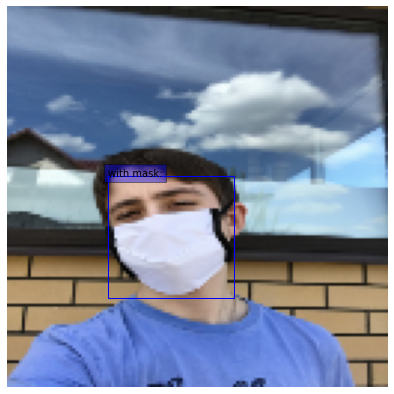

In [11]:
# verify that each bounding box and each label is still at the same index as the relative image
index = 430
bbox = convert_to_minmax(bounding_box_tensor[index])
scaled_bbox = rescale_bbox(feature_tensor[index].shape, bbox)
label = 0 if labels_tensor[index][1].numpy() == 0 else 1
visualize_detections(feature_tensor[index], scaled_bbox, label)

In [12]:
# split in training set and test set
feature_test_set = feature_tensor[:test_set_size]
feature_tensor = feature_tensor[test_set_size:]
bounding_box_test_set = bounding_box_tensor[:test_set_size]
bounding_box_tensor = bounding_box_tensor[test_set_size:]
labels_test_set = labels_tensor[:test_set_size]
labels_tensor = labels_tensor[test_set_size:]

The function in the next cell are an adaptation of the code used in the [Keras tutorial of RetinaNet](https://keras.io/examples/vision/retinanet/)

The function is used as a callback metric during training and test for measuring the performance of the regression head

In [13]:
def IoU_metric(y_true, y_pred):
    # y_true is a tensor representing the ground truth bounding boxes for a given batch of samples (in format xywh)
    # y_pred is a tensor representing the predicted bounding boxes for the same batch of samples (in format xywh)
    # the function computes the IoU score for each couple (ground truth bounding box, predicted bounding box)
    boxes1_corners = convert_to_minmax(y_true)
    boxes2_corners = convert_to_minmax(y_pred)
    # compute the intersection area
    lu = tf.maximum(boxes1_corners[:, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, 0] * intersection[:, 1]
    # compute the union area
    boxes1_area = y_true[:, 2] * y_true[:, 3]
    boxes2_area = y_pred[:, 2] * y_pred[:, 3]  
    union_area = tf.maximum(
        boxes1_area + boxes2_area - intersection_area, 1e-8
    )
    # compute IoU
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [29]:
from tensorflow import keras

# instantiate the model
input = keras.Input(shape=(128,128,3), name="input")
model = keras.layers.Conv2D(2, (3, 3), activation='relu')(input)
model = keras.layers.MaxPooling2D((2, 2))(model)
model = keras.layers.Conv2D(4, (3, 3), activation='relu')(model)
model = keras.layers.MaxPooling2D((2, 2))(model)
model = keras.layers.Conv2D(8, (3, 3), activation='relu')(model)
model = keras.layers.Flatten()(model)
model = keras.layers.Dropout(0.5)(model)
classification_head = keras.layers.Dense(2, activation='softmax', name="labels")(model)
regression_head = keras.layers.Dense(4, activation='sigmoid', name="bounding_box")(model)

In [30]:
# define input and outputs of the model
model = keras.Model(
    inputs=input,
    outputs=[classification_head, regression_head],
)

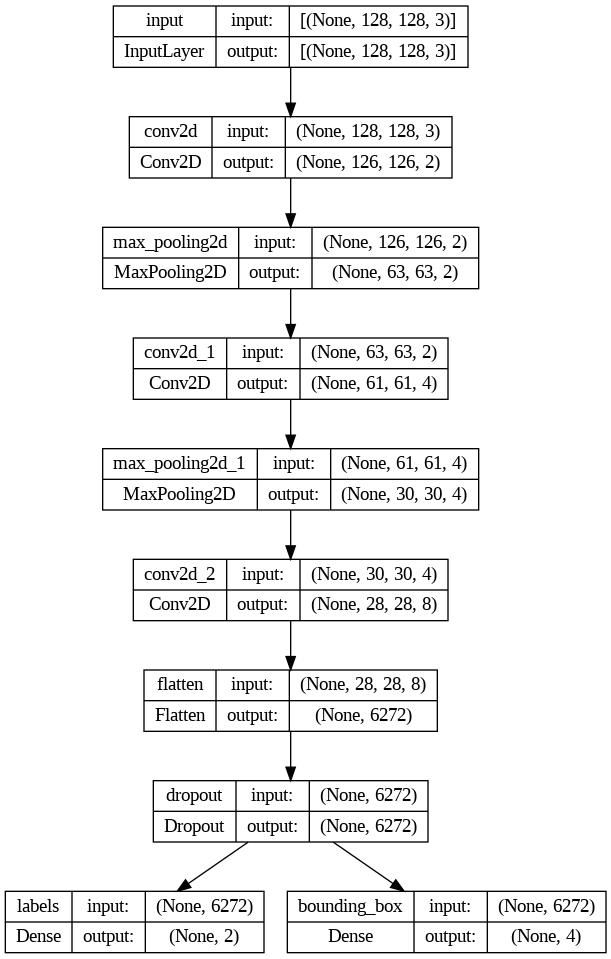

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 2)  56          ['input[0][0]']                  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 2)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 61, 61, 4)    76          ['max_pooling2d[0][0]']      

In [31]:
# compile the model
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),

    # define which loss to use for each head of the network
    loss=[
        keras.losses.CategoricalCrossentropy(),
        keras.losses.MeanSquaredError(),
    ],

    # the total loss is a linear combination of the two losses of the network, here we define the weights of each loss
    loss_weights=[0.15, 1.0],

    # define which metrics to use for each head of the network, here we select our custom callback function IoU_metric() for the regression head
    metrics={'labels':'accuracy', 'bounding_box': [IoU_metric]}
)

# this is done to implement early stopping
model_dir = "models/"
experiment = "scratch_cnn_exp2.h5"
save_path = os.path.join(model_dir, experiment)

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    # we save the model with the lowest validation total loss
    monitor="val_loss",
    verbose=1,
    save_best_only=True)
]

In [32]:
history = model.fit(
              {"input": feature_tensor},
              {"labels": labels_tensor, "bounding_box": bounding_box_tensor},
              epochs=10,
              batch_size=32,
              validation_split=0.2,
              shuffle=True,
              callbacks = callbacks_list
          )

Epoch 1/10
43/43 [==============================] - ETA: 0s - loss: 1.9691 - labels_loss: 11.5245 - bounding_box_loss: 0.2405 - labels_accuracy: 0.6219 - bounding_box_IoU_metric: 2.2914e-04
Epoch 1: val_loss improved from inf to 0.32310, saving model to models/scratch_cnn_exp2.h5
43/43 [==============================] - 12s 243ms/step - loss: 1.9691 - labels_loss: 11.5245 - bounding_box_loss: 0.2405 - labels_accuracy: 0.6219 - bounding_box_IoU_metric: 2.2914e-04 - val_loss: 0.3231 - val_labels_loss: 1.3371 - val_bounding_box_loss: 0.1225 - val_labels_accuracy: 0.5948 - val_bounding_box_IoU_metric: 1.9092e-05
Epoch 2/10
43/43 [==============================] - ETA: 0s - loss: 0.2731 - labels_loss: 1.1604 - bounding_box_loss: 0.0990 - labels_accuracy: 0.6409 - bounding_box_IoU_metric: 0.0149
Epoch 2: val_loss improved from 0.32310 to 0.14423, saving model to models/scratch_cnn_exp2.h5
43/43 [==============================] - 11s 266ms/step - loss: 0.2731 - labels_loss: 1.1604 - bounding_

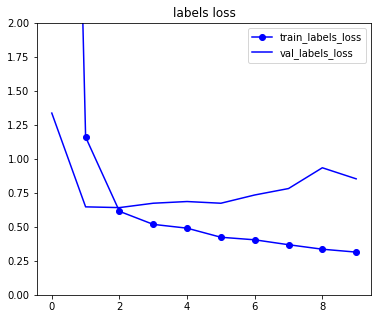

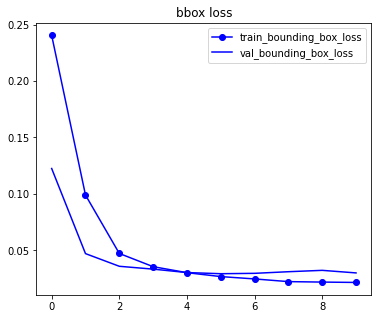

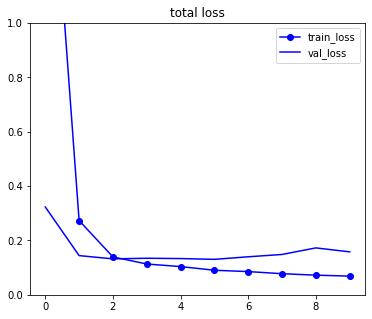

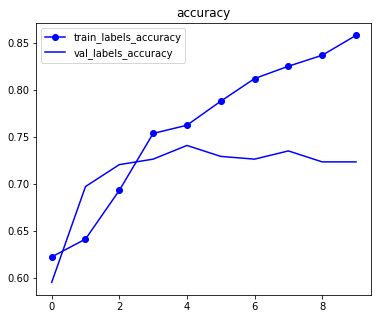

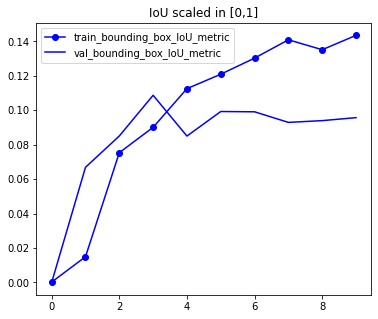

In [33]:
#plot the history of the training

plt.figure(figsize=(6,5))
plt.title('labels loss')
plt.plot(history.history['labels_loss'],'bo-',label = 'train_labels_loss')
plt.plot(history.history['val_labels_loss'],'b-',label = 'val_labels_loss')
plt.ylim(0, 2)
plt.legend()
plt.show()

plt.figure(figsize=(6,5))
plt.title('bbox loss')
plt.plot(history.history['bounding_box_loss'],'bo-',label = 'train_bounding_box_loss')
plt.plot(history.history['val_bounding_box_loss'],'b-',label = 'val_bounding_box_loss')
plt.legend()
plt.show()

plt.figure(figsize=(6,5))
plt.title('total loss')
plt.plot(history.history['loss'],'bo-',label = 'train_loss')
plt.plot(history.history['val_loss'],'b-',label = 'val_loss')
plt.ylim(0, 1)
plt.legend()
plt.show()


plt.figure(figsize=(6,5))
plt.title('accuracy')
plt.plot(history.history['labels_accuracy'],'bo-',label = 'train_labels_accuracy')
plt.plot(history.history['val_labels_accuracy'],'b-',label = 'val_labels_accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(6,5))
plt.title('IoU scaled in [0,1]')
plt.plot(history.history['bounding_box_IoU_metric'],'bo-',label = 'train_bounding_box_IoU_metric')
plt.plot(history.history['val_bounding_box_IoU_metric'],'b-',label = 'val_bounding_box_IoU_metric')
plt.legend()
plt.show()

In [34]:
from tensorflow.keras.models import load_model

# delete the current model
del model

# load the model saved by the early stopping callback
model = load_model(os.path.join(model_dir, experiment), custom_objects={"IoU_metric": IoU_metric})

#evaluate the model on the test set
model.evaluate({"input": feature_test_set},
               {"labels": labels_test_set, "bounding_box": bounding_box_test_set}, 
               return_dict=True)

14/14 [==============================] - 1s 84ms/step - loss: 0.1326 - labels_loss: 0.6894 - bounding_box_loss: 0.0292 - labels_accuracy: 0.6939 - bounding_box_IoU_metric: 0.1054


{'loss': 0.13264121115207672,
 'labels_loss': 0.6893960237503052,
 'bounding_box_loss': 0.029231810942292213,
 'labels_accuracy': 0.6939252614974976,
 'bounding_box_IoU_metric': 0.10541630536317825}

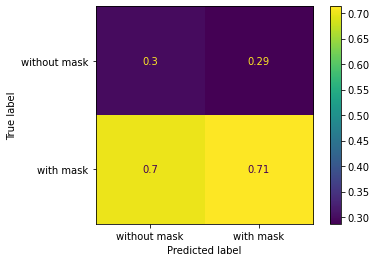

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# create and plot the confusion matrix
predictions = model(feature_test_set)
result = confusion_matrix(tf.math.argmax(labels_test_set, axis=1), tf.math.argmax(predictions[0], axis=1), normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['without mask', 'with mask'])
disp.plot()
plt.show()

In [36]:
# save the model to google drive
!cp ./models/scratch_cnn_exp2.h5 /content/drive/MyDrive/CIDL_Project/models/

In [37]:
# verify that the model was uploaded to drive
drive_dir_model = "/content/drive/MyDrive/CIDL_Project/models/"
model = load_model(os.path.join(drive_dir_model, experiment), custom_objects={"IoU_metric": IoU_metric})
model.evaluate({"input": feature_test_set},
               {"labels": labels_test_set, "bounding_box": bounding_box_test_set}, 
               return_dict=True)

14/14 [==============================] - 2s 86ms/step - loss: 0.1326 - labels_loss: 0.6894 - bounding_box_loss: 0.0292 - labels_accuracy: 0.6939 - bounding_box_IoU_metric: 0.1054


{'loss': 0.13264121115207672,
 'labels_loss': 0.6893960237503052,
 'bounding_box_loss': 0.029231810942292213,
 'labels_accuracy': 0.6939252614974976,
 'bounding_box_IoU_metric': 0.10541630536317825}